In [35]:
import sys, os

import numpy as np
from numpy import expand_dims

# The way tensorflow is imported might be changed to work with gpus
import tensorflow as tf

import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
    

In [36]:
def pad_image(image, max_size = (25,25)):
    """
    Simply pad an image with zeros up to max_size.
    """
    size = np.shape(image)
    px, py = (max_size[0]-size[0]), (max_size[1]-size[1])
    a1=int(np.floor(px/2.0))
    a2=int(np.ceil(px/2.0))
    a3=int(np.floor(py/2.0))
    a4=int(np.ceil(py/2.0))
    image = np.pad(image, ((a1, a2), (a3, a4)), 'constant', constant_values=(0))
    #image = np.pad(image, (map(int,((np.floor(px/2.), np.ceil(px/2.)))), map(int,(np.floor(py/2.), np.ceil(py/2.)))), 'constant')
    return image




def normalize(histo, multi=255):
    """
    Normalize picture in [0,multi] range, with integer steps. E.g. multi=255 for 256 steps.
    """
    return (histo/np.max(histo)*multi).astype(int)

In [37]:
#Number events for each set of data
NUMBER_EVENTS = 40000

NUMBER_TRAIN = 50
BATCH_SIZE = 32
EPOCHS = 50

In [38]:
notebook_path = os.path.abspath("CNN_for_jettagging.ipynb")

qcd_file_path = os.path.join(os.path.dirname(notebook_path), "qcd_leading_jet.npz")
top_file_path = os.path.join(os.path.dirname(notebook_path), "top_leading_jet.npz")

qcd_npz_file = np.load(qcd_file_path, allow_pickle=True, encoding='bytes')
top_npz_file = np.load(top_file_path, allow_pickle=True, encoding='bytes')

qcd_data = qcd_npz_file['arr_0']
top_data = top_npz_file['arr_0']
print(qcd_data[30000])

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.91701451e-01 0.00000000e+00 4.13739640e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.16016773e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.91702352e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00

In [39]:
print("qcd data shape: ", qcd_data.shape)
print("top data shape: ",top_data.shape)

#Added automation to slecting N events 
#+1 as np deletes up to and not including upper limit
qcd_number_to_remove = (qcd_data.shape[0] - NUMBER_EVENTS) + 1
top_number_to_remove = (top_data.shape[0] - NUMBER_EVENTS) + 1

#Pick the N events 
qcd_data = np.delete(qcd_data ,np.s_[1:qcd_number_to_remove],0)
top_data = np.delete(top_data ,np.s_[1:top_number_to_remove],0)

print('We have {} QCD jets and {} top jets'.format(len(qcd_data), len(top_data)))

qcd data shape:  (60713,)
top data shape:  (61761,)
We have 40000 QCD jets and 40000 top jets


In [40]:
# objects and labels
x_data = np.concatenate((qcd_data, top_data))
y_data = np.array([0]*len(qcd_data)+[1]*len(top_data))


print("xdatashape",x_data.shape)

x_data = list(x_data)

xdatashape (80000,)


In [41]:
# pad and normalize images
x_data = list(map(pad_image, x_data))
x_data = list(map(normalize, x_data))

In [42]:
# shapeuffle
np.random.seed(0) # for reproducibility
x_data, y_data = np.random.permutation(np.array([x_data, y_data]).T).T


# the data coming out of previous commands is a list of 2D arrays. We want a 3D np array (n_events, xpixels, ypixels)
x_data = np.stack(x_data)

print("xshape-after stack",x_data.shape)

x_data = expand_dims(x_data, axis=3)
y_data = keras.utils.to_categorical(y_data, 2)

/tmp/ipykernel_12559/2070534313.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_data, y_data = np.random.permutation(np.array([x_data, y_data]).T).T


xshape-after stack (80000, 25, 25)


In [43]:
(x_train, x_test) = x_data[:NUMBER_TRAIN], x_data[NUMBER_TRAIN:]
(y_train, y_test) = y_data[:NUMBER_TRAIN], y_data[NUMBER_TRAIN:]

In [45]:
# start with a small CNN
cnn_tagging_model = Sequential()
cnn_tagging_model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(25, 25, 1)))
cnn_tagging_model.add(MaxPooling2D((3, 3)))
cnn_tagging_model.add(Conv2D(16, (3, 3), activation='relu'))
cnn_tagging_model.add(MaxPooling2D((2, 2)))
cnn_tagging_model.add(Flatten())
cnn_tagging_model.add(Dense(2, activation='softmax'))

In [46]:
# we can experiment with different loss functions
cnn_tagging_model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])
cnn_tagging_model.summary()

save_path = qcd_file_path = os.path.join(os.path.dirname(notebook_path), "cnn_tagging_model.tf")
cnn_tagging_model.save_weights(save_path)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 23, 23, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 5, 16)          1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                

In [47]:
history = cnn_tagging_model.fit(x_train, y_train,
                       batch_size=BATCH_SIZE, 
                       epochs=3*EPOCHS,
                       verbose=2,
                       validation_data=(x_test, y_test))

Epoch 1/150


2023-02-07 20:42:26.255478: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 399750000 exceeds 10% of free system memory.


2/2 - 12s - loss: 10.3097 - accuracy: 0.2600 - val_loss: 4.5346 - val_accuracy: 0.4635 - 12s/epoch - 6s/step
Epoch 2/150
2/2 - 10s - loss: 2.8336 - accuracy: 0.6000 - val_loss: 3.2478 - val_accuracy: 0.5399 - 10s/epoch - 5s/step
Epoch 3/150
2/2 - 9s - loss: 1.7467 - accuracy: 0.6800 - val_loss: 3.6266 - val_accuracy: 0.5865 - 9s/epoch - 4s/step
Epoch 4/150
2/2 - 10s - loss: 1.4327 - accuracy: 0.7600 - val_loss: 2.9173 - val_accuracy: 0.6175 - 10s/epoch - 5s/step
Epoch 5/150
2/2 - 8s - loss: 1.2323 - accuracy: 0.7200 - val_loss: 3.5472 - val_accuracy: 0.5940 - 8s/epoch - 4s/step
Epoch 6/150
2/2 - 8s - loss: 1.1350 - accuracy: 0.7800 - val_loss: 2.1148 - val_accuracy: 0.6366 - 8s/epoch - 4s/step
Epoch 7/150
2/2 - 7s - loss: 0.5727 - accuracy: 0.8400 - val_loss: 2.2397 - val_accuracy: 0.6566 - 7s/epoch - 4s/step
Epoch 8/150
2/2 - 8s - loss: 0.5414 - accuracy: 0.8800 - val_loss: 2.1642 - val_accuracy: 0.6492 - 8s/epoch - 4s/step
Epoch 9/150
2/2 - 9s - loss: 0.4102 - accuracy: 0.8600 - val_

Epoch 70/150
2/2 - 8s - loss: 0.2311 - accuracy: 0.9000 - val_loss: 1.9660 - val_accuracy: 0.7329 - 8s/epoch - 4s/step
Epoch 71/150
2/2 - 10s - loss: 0.0732 - accuracy: 0.9800 - val_loss: 2.0171 - val_accuracy: 0.7267 - 10s/epoch - 5s/step
Epoch 72/150
2/2 - 7s - loss: 0.0566 - accuracy: 0.9800 - val_loss: 2.2374 - val_accuracy: 0.7074 - 7s/epoch - 4s/step
Epoch 73/150
2/2 - 8s - loss: 0.0603 - accuracy: 0.9800 - val_loss: 2.0762 - val_accuracy: 0.6874 - 8s/epoch - 4s/step
Epoch 74/150
2/2 - 7s - loss: 0.5079 - accuracy: 0.9000 - val_loss: 2.0748 - val_accuracy: 0.7236 - 7s/epoch - 4s/step
Epoch 75/150
2/2 - 8s - loss: 0.0772 - accuracy: 0.9800 - val_loss: 2.0613 - val_accuracy: 0.6906 - 8s/epoch - 4s/step
Epoch 76/150
2/2 - 7s - loss: 0.1934 - accuracy: 0.9200 - val_loss: 1.9292 - val_accuracy: 0.7354 - 7s/epoch - 4s/step
Epoch 77/150
2/2 - 8s - loss: 0.0963 - accuracy: 0.9600 - val_loss: 1.9918 - val_accuracy: 0.7254 - 8s/epoch - 4s/step
Epoch 78/150
2/2 - 8s - loss: 0.0588 - accurac

Epoch 139/150
2/2 - 7s - loss: 0.0277 - accuracy: 1.0000 - val_loss: 2.3169 - val_accuracy: 0.7249 - 7s/epoch - 4s/step
Epoch 140/150
2/2 - 8s - loss: 0.0433 - accuracy: 0.9800 - val_loss: 2.3944 - val_accuracy: 0.7195 - 8s/epoch - 4s/step
Epoch 141/150
2/2 - 7s - loss: 0.0671 - accuracy: 0.9600 - val_loss: 2.6086 - val_accuracy: 0.7038 - 7s/epoch - 4s/step
Epoch 142/150
2/2 - 8s - loss: 0.1087 - accuracy: 0.9600 - val_loss: 2.7554 - val_accuracy: 0.6943 - 8s/epoch - 4s/step
Epoch 143/150
2/2 - 7s - loss: 0.0915 - accuracy: 0.9800 - val_loss: 2.4080 - val_accuracy: 0.7183 - 7s/epoch - 4s/step
Epoch 144/150
2/2 - 9s - loss: 0.0418 - accuracy: 0.9800 - val_loss: 2.2640 - val_accuracy: 0.7003 - 9s/epoch - 4s/step
Epoch 145/150
2/2 - 7s - loss: 0.2156 - accuracy: 0.9400 - val_loss: 3.3702 - val_accuracy: 0.6649 - 7s/epoch - 4s/step
Epoch 146/150
2/2 - 8s - loss: 0.1459 - accuracy: 0.9600 - val_loss: 2.5172 - val_accuracy: 0.6474 - 8s/epoch - 4s/step
Epoch 147/150
2/2 - 7s - loss: 0.9674 - 

In [58]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss', 'val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['accuracy', 'val_accuracy'], ax=ax2)
    max_acc = hist['val_accuracy'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_accuracy) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

          loss  accuracy  val_loss  val_accuracy
0    10.309689      0.26  4.534610      0.463515
1     2.833605      0.60  3.247758      0.539887
2     1.746686      0.68  3.626600      0.586529
3     1.432697      0.76  2.917312      0.617511
4     1.232310      0.72  3.547209      0.593971
..         ...       ...       ...           ...
145   0.145872      0.96  2.517193      0.647430
146   0.967416      0.76  2.255901      0.731094
147   0.029861      1.00  2.301119      0.730544
148   0.032337      0.98  2.235595      0.713296
149   0.089386      0.96  2.232317      0.711407

[150 rows x 4 columns]


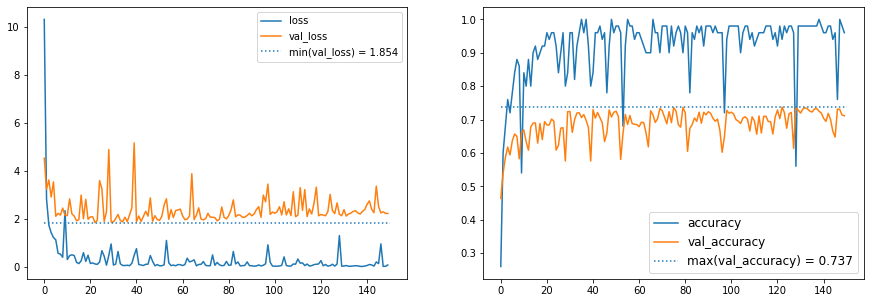

In [59]:
histplot(history)